In [1]:
%matplotlib inline

import nengo
import tensorflow as tf
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
with nengo.Network() as net:
    i_1 = nengo.Node(output=lambda t: random.random())
    i_2 = nengo.Node(output=lambda t: random.random())
    
    net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear()
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Uniform(-1, 1)
    net.config[nengo.Connection].synapse = None
    
    a = nengo.Ensemble(100, 1, neuron_type=nengo.RectifiedLinear())
    b = nengo.Ensemble(100, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(i_1, a)
    nengo.Connection(i_2, b)
    
    c = nengo.Ensemble(220, 2, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(a, c[0])
    nengo.Connection(b, c[1])
    
    d = nengo.Ensemble(100, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(c[0], d)
    nengo.Connection(c[1], d)
        
    i_1_probe = nengo.Probe(i_1)
    i_2_probe = nengo.Probe(i_2)
    output_probe = nengo.Probe(d)

In [3]:
n_steps = 50
minibatch_size = 100

## Without any training the output of the network roughly follows the pattern of the output but is very innaccurate

Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
Simulation completed in 0:00:00


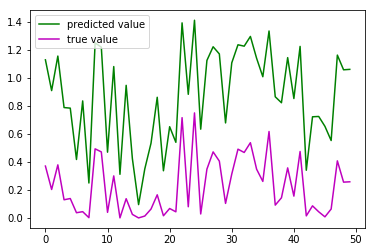

In [4]:

# Showing the output of the model pre training
with nengo_dl.Simulator(net) as sim:
    # run the simulation for 25 steps
    sim.run_steps(n_steps)
    true_value = np.multiply(sim.data[i_1_probe], sim.data[i_2_probe])
    plt.plot(sim.data[output_probe], 'g', label='predicted value')
    plt.plot(true_value, 'm', label='true value')
    plt.legend()

In [5]:
# Showing the trained version
with nengo_dl.Simulator(net, step_blocks=n_steps, minibatch_size=minibatch_size, device="/cpu:0") as sim:
    
    test_feed_1 = np.random.uniform(0, 1, size=(100, n_steps, 1))
    test_feed_2 = np.random.uniform(0, 1, size=(100, n_steps, 1))
    test_output = np.multiply(test_feed_1, test_feed_2)
    
    outputs = []
    sim.run_steps(n_steps, input_feeds={i_1:test_feed_1, i_2:test_feed_2})  
    outputs.append((sim.data[output_probe][0].flatten()))
    # running through 20 rounds of training, then testing
    for i in range(0, 5):
        i_1_input_feed = np.random.uniform(0, 1, size=(1000, n_steps, 1))
        i_2_input_feed = np.random.uniform(0, 1, size=(1000, n_steps, 1))
        output_feed = np.multiply(i_2_input_feed, i_1_input_feed)
        sim.train({i_1:i_1_input_feed, i_2:i_2_input_feed}, 
                  {output_probe: output_feed},
                 tf.train.MomentumOptimizer(5e-3, 0.9), n_epochs=1)
        sim.soft_reset(include_probes=True)
        sim.run_steps(n_steps, input_feeds={i_1:test_feed_1, i_2:test_feed_2})
        outputs.append((sim.data[output_probe][0].flatten()))

Building completed in 0:00:00 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
Simulation completed in 0:00:00
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:01
Simulation completed in 0:00:00
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:01
Simulation completed in 0:00:00
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:01
Simulation completed in 0:00:00
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:01
Simulation completed in 0:00:00
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:01
Simulation completed in 0:00:00


## Visually it can be seen that the network becomes more accurate the more training it receives

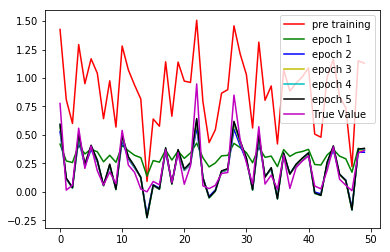

In [6]:
    # TODO LABEL GRAPH
    plt.plot(outputs[0], 'r', label='pre training')
    plt.plot(outputs[1], 'g', label='epoch 1')
    plt.plot(outputs[2], 'b', label='epoch 2')
    plt.plot(outputs[3], 'y', label='epoch 3')
    plt.plot(outputs[4], 'c', label='epoch 4')
    plt.plot(outputs[5], 'k', label='epoch 5')
    plt.plot(test_output[0].flatten(), 'm', label='True Value')
    plt.legend()

## Plotting the root mean squared error over time it is shown that the initial training yields large returns, diminishing gradually over time as the network learns to multiply the numbers

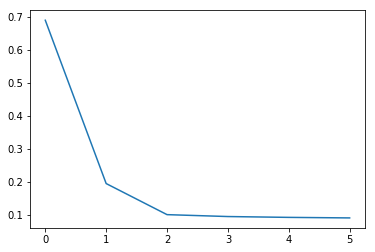

In [7]:
    # TODO label graph
    errors = []
    for o in outputs:
        errors.append(sqrt(mean_squared_error(test_output[0].flatten(), o)))
    plt.plot(errors)